In [42]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

# EDA를 통한 각 지표 확인
## 데이터 구조 점검 및 변수 이해
### 데이터 준비

In [43]:
import pandas as pd

In [44]:
df = pd.read_csv('data/마늘_이상치제거_주간기준_등급코드.csv', encoding='cp949')
df_grow = pd.read_csv('data/factor_external_weekly.csv', encoding='utf-8')

In [45]:
# item_code 생성
df['item_code'] = '1209'  # 거래데이터에는 대분류 코드가 없고 한 종류만 있음

df_grow['item_code'] = df_grow['item_code'].astype(str) 
df_grow['item_code'] = df_grow['item_code'].str.zfill(4)

In [46]:
# weekno 열을 만들고 주차 표기를 통일시켜 merge 준비
def get_week_of_year(date):
    date = pd.to_datetime(date)
    year = date.year
    week_number = date.isocalendar().week
    return f"{year}{week_number:02d}"

df['weekno'] = df['연월일'].apply(get_week_of_year)

In [47]:
def format_week_int(week_no):
    # week_no가 202401, 202402 등 정수형이면
    week_no = int(week_no)
    year = week_no // 100
    week = week_no % 100
    return f"{year}{week:02d}"

df_grow['weekno'] = df_grow['week_no'].apply(format_week_int)

In [48]:
# 기 생성된 휴일여부	명절지수	작기정보 칼럼 삭제
df.drop(columns=['휴일여부', '명절지수', '작기정보'], inplace=True)

In [49]:
# 병합하기
merged_df  = pd.merge( df,
                    df_grow[['weekno', 'item_code', 'holiday_flag', 'holiday_score', 'grow_score']],
                    left_on=['weekno', 'item_code'],
                    right_on=['weekno', 'item_code'],
                    how='left'
                )
merged_df.head()

,주차,연월일,품목코드,품목명,품종코드,품종명,등급코드,등급이름,총금액(원),총거래량(kg),...,최고기온,최저기온,평균상대습도,강수량(mm),1시간최고강수량(mm),item_code,weekno,holiday_flag,holiday_score,grow_score
0,2018-01-01~2018-01-07,2018-01-02,9,마늘,5,풋마늘,12,중,114900.0,30.0,...,8.9,-3.3,59.8,-9.0,-9.0,1209,201801,3,0.0,0.0
1,2018-01-01~2018-01-07,2018-01-02,9,마늘,99,기타마늘,12,중,11718.0,2.0,...,1.8,-4.3,42.0,-9.0,-9.0,1209,201801,3,0.0,0.0
2,2018-01-01~2018-01-07,2018-01-02,9,마늘,99,기타마늘,12,중,146497.0,25.0,...,1.8,-4.3,42.0,-9.0,-9.0,1209,201801,3,0.0,0.0
3,2018-01-01~2018-01-07,2018-01-02,9,마늘,17,마늘쫑(수입),13,저,45802.0,20.0,...,1.8,-4.3,42.0,-9.0,-9.0,1209,201801,3,0.0,0.0
4,2018-01-01~2018-01-07,2018-01-02,9,마늘,17,마늘쫑(수입),13,저,184000.0,64.0,...,6.7,-3.2,74.6,0.0,-9.0,1209,201801,3,0.0,0.0


In [50]:
# 강수량, 1시간최고 강수량은 결측치(-9) 혹은 비가 안옴(0)이 많아 0 이하는 0으로 처리
# merged_df['강수량(mm)'] = merged_df['강수량(mm)'<=0].count()
merged_df.loc[merged_df['강수량(mm)']<=0, '강수량(mm)'] = 0
merged_df.loc[merged_df['1시간최고강수량(mm)']<=0, '1시간최고강수량(mm)'] = 0

In [51]:
# 일간 거래 데이터 (필요한 열만 사용)
df_daily_galic = merged_df.loc[:, ['연월일', '품종코드', '등급코드', '총거래량(kg)','주간평균단가(원)','직팜산지코드','일평균기온','최고기온','최저기온','평균상대습도','강수량(mm)','1시간최고강수량(mm)', 'holiday_flag', 'holiday_score','grow_score', '총금액(원)']]
df_daily_galic.head()

,연월일,품종코드,등급코드,총거래량(kg),주간평균단가(원),직팜산지코드,일평균기온,최고기온,최저기온,평균상대습도,강수량(mm),1시간최고강수량(mm),holiday_flag,holiday_score,grow_score,총금액(원)
0,2018-01-02,5,12,30.0,4874.018048,1131,3.1,8.9,-3.3,59.8,0.0,0.0,3,0.0,0.0,114900.0
1,2018-01-02,99,12,2.0,4874.018048,1000,-1.8,1.8,-4.3,42.0,0.0,0.0,3,0.0,0.0,11718.0
2,2018-01-02,99,12,25.0,4874.018048,1000,-1.8,1.8,-4.3,42.0,0.0,0.0,3,0.0,0.0,146497.0
3,2018-01-02,17,13,20.0,4874.018048,1000,-1.8,1.8,-4.3,42.0,0.0,0.0,3,0.0,0.0,45802.0
4,2018-01-02,17,13,64.0,4874.018048,1107,0.7,6.7,-3.2,74.6,0.0,0.0,3,0.0,0.0,184000.0


In [52]:
# 주간 거래 데이터 병합
df_galic = merged_df.loc[:, ['weekno', '품종코드', '등급코드', '총금액(원)', '총거래량(kg)','직팜산지코드','일평균기온','최고기온','최저기온','평균상대습도','강수량(mm)','1시간최고강수량(mm)', 'holiday_flag', 'holiday_score','grow_score']]
df_weekly_galic = df_galic.groupby(['weekno', '품종코드', '등급코드', '직팜산지코드']).agg({
    '총금액(원)' : 'sum', 
    '총거래량(kg)' : 'sum', 
    '일평균기온': 'mean', 
    '최고기온': 'max', 
    '최저기온' : 'min', 
    '평균상대습도' : 'mean', 
    '강수량(mm)' : 'sum', 
    '1시간최고강수량(mm)' : 'sum', 
    'holiday_flag' : 'sum', 
    'holiday_score' : 'sum', 
    'grow_score' : 'sum'
}).reset_index()

In [53]:
# 주간 단가 계산
df_weekly_galic['평균단가(원)'] = round(df_weekly_galic['총금액(원)'] / df_weekly_galic['총거래량(kg)'])

# weekno에서 year, week 분리 (문자열 슬라이싱)
df_weekly_galic['year'] = df_weekly_galic['weekno'].astype(str).str[:4]
df_weekly_galic['week'] = df_weekly_galic['weekno'].astype(str).str[4:]

# 주간 시작일 입력 (시계열 특성 - prophet)
import datetime

def year_week_to_date(year, week):
    # ISO 주차는 매년 첫 번째 주의 월요일이 기준
    return datetime.date.fromisocalendar(int(year), int(week), 1)  # 1: 월요일

df_weekly_galic['week_start'] = df_weekly_galic.apply(lambda row: year_week_to_date(row['year'], row['week']), axis=1)
df_weekly_galic['week_start'] = pd.to_datetime(df_weekly_galic['week_start'])
df_weekly_galic.drop(columns='weekno', inplace=True)

In [54]:
# 저장
df_daily_galic.to_csv('data/trade_daily_galic.csv', encoding='cp949', index=False)
df_weekly_galic.to_csv('data/trade_weekly_galic.csv', encoding='cp949', index=False)

# 샘플파일 생성 (chat과 편안한 상담용 )
df_daily_galic_sample = df_daily_galic.iloc[:100]
df_daily_galic_sample.to_csv('data/trade_daily_galic_sample.csv', encoding='cp949', index=False)
df_weekly_galic_sample = df_weekly_galic.iloc[:100]
df_weekly_galic_sample.to_csv('data/trade_weekly_galic_sample.csv', encoding='cp949', index=False)

In [55]:
df_weekly_galic_sample

,품종코드,등급코드,직팜산지코드,총금액(원),총거래량(kg),일평균기온,최고기온,최저기온,평균상대습도,강수량(mm),1시간최고강수량(mm),holiday_flag,holiday_score,grow_score,평균단가(원),year,week,week_start
0,0,11,1000,740240.0,118.0,-4.450000,1.6,-10.5,43.325000,0.0,0.0,12,0.0,0.0,6273.0,2018,01,2018-01-01
1,0,13,1030,50400.0,15.0,-3.900000,-1.0,-6.9,62.500000,0.0,0.0,3,0.0,0.0,3360.0,2018,01,2018-01-01
2,1,11,1121,23680.0,4.0,-0.500000,6.8,-8.2,41.600000,0.0,0.0,3,0.0,0.0,5920.0,2018,01,2018-01-01
3,1,12,1121,24773520.0,5506.0,1.600000,8.8,-5.2,32.200000,0.0,0.0,12,0.0,0.0,4499.0,2018,01,2018-01-01
4,1,12,1138,17180000.0,3200.0,1.420000,6.5,-8.3,35.720000,0.0,0.0,15,0.0,0.0,5369.0,2018,01,2018-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6,11,1164,2608000.0,400.0,-3.033333,2.9,-13.2,72.666667,0.0,0.0,9,0.0,0.0,6520.0,2018,01,2018-01-01
96,6,11,1170,2016000.0,320.0,4.600000,5.8,3.5,58.600000,0.0,0.0,3,0.0,0.0,6300.0,2018,01,2018-01-01
97,6,12,1000,189946634.0,33036.0,-4.048148,1.8,-10.5,44.209259,0.0,0.0,162,0.0,0.0,5750.0,2018,01,2018-01-01
98,6,12,1001,5419000.0,932.0,-4.960000,3.5,-11.7,63.810000,0.0,0.0,30,0.0,0.0,5814.0,2018,01,2018-01-01


In [56]:
df_weekly_galic

,품종코드,등급코드,직팜산지코드,총금액(원),총거래량(kg),일평균기온,최고기온,최저기온,평균상대습도,강수량(mm),1시간최고강수량(mm),holiday_flag,holiday_score,grow_score,평균단가(원),year,week,week_start
0,0,11,1000,740240.0,118.0,-4.450000,1.6,-10.5,43.325000,0.0,0.0,12,0.0,0.0,6273.0,2018,01,2018-01-01
1,0,13,1030,50400.0,15.0,-3.900000,-1.0,-6.9,62.500000,0.0,0.0,3,0.0,0.0,3360.0,2018,01,2018-01-01
2,1,11,1121,23680.0,4.0,-0.500000,6.8,-8.2,41.600000,0.0,0.0,3,0.0,0.0,5920.0,2018,01,2018-01-01
3,1,12,1121,24773520.0,5506.0,1.600000,8.8,-5.2,32.200000,0.0,0.0,12,0.0,0.0,4499.0,2018,01,2018-01-01
4,1,12,1138,17180000.0,3200.0,1.420000,6.5,-8.3,35.720000,0.0,0.0,15,0.0,0.0,5369.0,2018,01,2018-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121913,99,13,1135,131000.0,44.5,16.700000,22.9,12.8,75.100000,0.0,0.0,2,0.0,0.0,2944.0,2025,22,2025-05-26
121914,99,13,1157,131000.0,54.5,17.916667,28.5,9.6,69.616667,0.0,0.0,12,0.0,0.0,2404.0,2025,22,2025-05-26
121915,99,13,1158,3252700.0,1642.0,19.027273,27.7,11.8,66.381818,0.0,0.0,22,0.0,0.0,1981.0,2025,22,2025-05-26
121916,99,13,1159,4121900.0,1880.2,17.141176,23.3,13.2,77.376471,2.4,2.4,34,0.0,0.0,2192.0,2025,22,2025-05-26


In [57]:
df = pd.concat([df_weekly_galic.drop(columns=['평균단가(원)', '총금액(원)']), df_weekly_galic.iloc[:, -4]], axis=1)

In [59]:
df.to_csv('data/trade_weekly_galic.csv', encoding='cp949', index=False)

# 모델링

In [63]:
import pandas as pd
import numpy as np

In [ ]:
df_weekly_galic = pd.read_csv('data/trade_weekly_galic.csv', encoding='cp949')

In [60]:
print(df_weekly_galic.isna().sum())  # 대체로 산지가 없거나 수입산인 경우 기후 데이터 없음
df_weekly_galic_drop = df_weekly_galic.dropna()

품종코드                0
등급코드                0
직팜산지코드              0
총금액(원)              0
총거래량(kg)            0
일평균기온            3087
최고기온             3087
최저기온             3087
평균상대습도           3087
강수량(mm)             0
1시간최고강수량(mm)        0
holiday_flag        0
holiday_score       0
grow_score          0
평균단가(원)             0
year                0
week                0
week_start          0
dtype: int64


In [62]:
df_weekly_galic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121918 entries, 0 to 121917
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   품종코드           121918 non-null  int64         
 1   등급코드           121918 non-null  int64         
 2   직팜산지코드         121918 non-null  int64         
 3   총금액(원)         121918 non-null  float64       
 4   총거래량(kg)       121918 non-null  float64       
 5   일평균기온          118831 non-null  float64       
 6   최고기온           118831 non-null  float64       
 7   최저기온           118831 non-null  float64       
 8   평균상대습도         118831 non-null  float64       
 9   강수량(mm)        121918 non-null  float64       
 10  1시간최고강수량(mm)   121918 non-null  float64       
 11  holiday_flag   121918 non-null  int64         
 12  holiday_score  121918 non-null  float64       
 13  grow_score     121918 non-null  float64       
 14  평균단가(원)        121918 non-null  float64       
 15  

In [1]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# 데이터 로드
df = pd.read_csv('data/trade_weekly_galic.csv', encoding='cp949', parse_dates=['week_start'])
print(df.shape)
df.head()

(121918, 17)


,품종코드,등급코드,직팜산지코드,총거래량(kg),일평균기온,최고기온,최저기온,평균상대습도,강수량(mm),1시간최고강수량(mm),holiday_flag,holiday_score,grow_score,year,week,week_start,평균단가(원)
0,0,11,1000,118.0,-4.45,1.6,-10.5,43.325,0.0,0.0,12,0.0,0.0,2018,1,2018-01-01,6273.0
1,0,13,1030,15.0,-3.90,-1.0,-6.9,62.500,0.0,0.0,3,0.0,0.0,2018,1,2018-01-01,3360.0
2,1,11,1121,4.0,-0.50,6.8,-8.2,41.600,0.0,0.0,3,0.0,0.0,2018,1,2018-01-01,5920.0
3,1,12,1121,5506.0,1.60,8.8,-5.2,32.200,0.0,0.0,12,0.0,0.0,2018,1,2018-01-01,4499.0
4,1,12,1138,3200.0,1.42,6.5,-8.3,35.720,0.0,0.0,15,0.0,0.0,2018,1,2018-01-01,5369.0


In [3]:
# 결측치 처리 (간단히 결측치 행 제거)
df = df.dropna()
print(df.isna().sum())

품종코드             0
등급코드             0
직팜산지코드           0
총거래량(kg)         0
일평균기온            0
최고기온             0
최저기온             0
평균상대습도           0
강수량(mm)          0
1시간최고강수량(mm)     0
holiday_flag     0
holiday_score    0
grow_score       0
year             0
week             0
week_start       0
평균단가(원)          0
dtype: int64


In [4]:
# feature/target 설정
X = df.drop(['평균단가(원)', 'week_start'], axis=1)
y = df['평균단가(원)']

In [5]:
# 범주형 변수 인코딩 (one-hot)
X = pd.get_dummies(X, columns=['품종코드', '등급코드', '직팜산지코드', 'year', 'week'])

In [6]:
# 학습/테스트 분리 (시계열 데이터라면 shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(X_train.shape, X_test.shape)

(95064, 264) (23767, 264)


In [7]:
# 모델 정의
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
xgb = XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1)
lgbm = LGBMRegressor(n_estimators=200, random_state=42, n_jobs=-1)

In [8]:
# 학습
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2922
[LightGBM] [Info] Number of data points in the train set: 95064, number of used features: 240
[LightGBM] [Info] Start training from score 4074.901056


LGBMRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [9]:
# 예측
pred_rf = rf.predict(X_test)
pred_xgb = xgb.predict(X_test)
pred_lgbm = lgbm.predict(X_test)

# 앙상블 (단순평균)
pred_ensemble = (pred_rf + pred_xgb + pred_lgbm) / 3

In [12]:
# 평가
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))
rmse_lgbm = np.sqrt(mean_squared_error(y_test, pred_lgbm))
rmse_ensemble = np.sqrt(mean_squared_error(y_test, pred_ensemble))

print(f'RF RMSE: {rmse_rf:.2f}')
print(f'XGB RMSE: {rmse_xgb:.2f}')
print(f'LGBM RMSE: {rmse_lgbm:.2f}')
print(f'Ensemble RMSE: {rmse_ensemble:.2f}')

RF RMSE: 1294.99
XGB RMSE: 1080.70
LGBM RMSE: 1143.21
Ensemble RMSE: 1129.92


# 모델 고도화

In [13]:
# 1. 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import shap

c:\Users\Admin\anaconda3\envs\ten\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
# 2. 데이터 로드 및 전처리
df = pd.read_csv('data/trade_weekly_galic.csv', encoding='cp949', parse_dates=['week_start'])
df = df.dropna()
X = df.drop(['평균단가(원)', 'week_start'], axis=1)
y = df['평균단가(원)']
X = pd.get_dummies(X, columns=['품종코드', '등급코드', '직팜산지코드', 'year', 'week'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [15]:
# 3. 하이퍼파라미터 튜닝 (예시: RandomForest)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_rf = GridSearchCV(rf, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train, y_train)
print("Best RF params:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

Best RF params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}


In [16]:
# 4. XGBoost, LightGBM 간단 튜닝 (필요시 GridSearchCV로 확장)
xgb = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1)
lgbm = LGBMRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2922
[LightGBM] [Info] Number of data points in the train set: 95064, number of used features: 240
[LightGBM] [Info] Start training from score 4074.901056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMRegressor(max_depth=6, n_estimators=200, n_jobs=-1, random_state=42)

In [17]:
# 5. Stacking 앙상블
stack = StackingRegressor(
    estimators=[
        ('rf', best_rf),
        ('xgb', xgb),
        ('lgbm', lgbm)
    ],
    final_estimator=RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)
stack.fit(X_train, y_train)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [20]:
# 6. 예측 및 평가
pred_rf = best_rf.predict(X_test)
pred_xgb = xgb.predict(X_test)
pred_lgbm = lgbm.predict(X_test)
# pred_stack = stack.predict(X_test)  # 스태킹 사용 시 활성화
pred_ensemble = (pred_rf + pred_xgb + pred_lgbm) / 3

print(f'RF RMSE: {np.sqrt(mean_squared_error(y_test, pred_rf)):.2f}')
print(f'XGB RMSE: {np.sqrt(mean_squared_error(y_test, pred_xgb)):.2f}')
print(f'LGBM RMSE: {np.sqrt(mean_squared_error(y_test, pred_lgbm)):.2f}')
print(f'Ensemble RMSE: {np.sqrt(mean_squared_error(y_test, pred_ensemble)):.2f}')
# print(f'Stacking RMSE: {np.sqrt(mean_squared_error(y_test, pred_stack)):.2f}')  # 스태킹 사용 시 활성화

RF RMSE: 1301.96
XGB RMSE: 1103.40
LGBM RMSE: 1090.77
Ensemble RMSE: 1119.16


c:\Users\Admin\anaconda3\envs\ten\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Admin\anaconda3\envs\ten\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Admin\anaconda3\envs\ten\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Admin\anaconda3\envs\ten\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Admin\anaconda3\envs\ten\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from current font.
  fig.canvas.print_fi

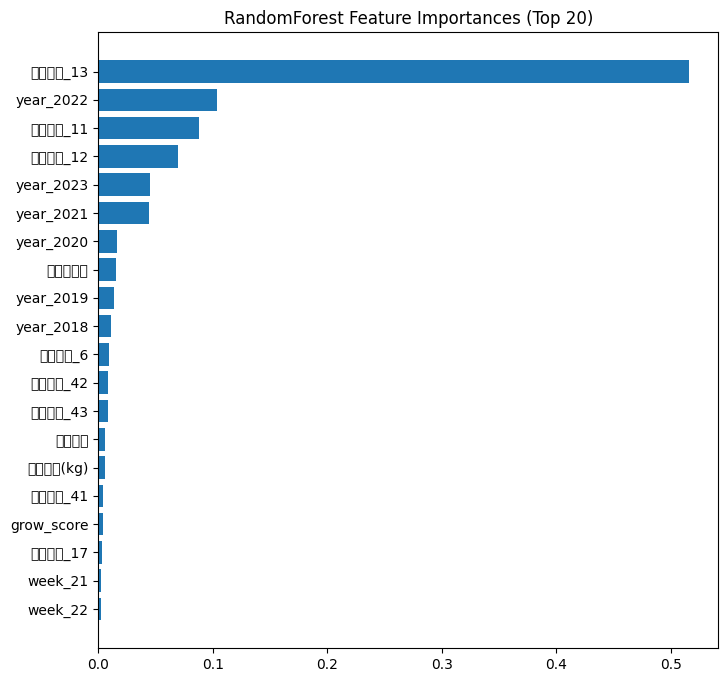

In [21]:
# 7. 변수 중요도 시각화 (예: RandomForest)
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-20:]  # 상위 20개
plt.figure(figsize=(8, 8))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.title("RandomForest Feature Importances (Top 20)")
plt.show()

In [22]:
# 8. SHAP 해석 (예: XGBoost)
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, max_display=20)

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'